In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

import pyLDAvis
from pyLDAvis.sklearn import prepare

In [2]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
12890,21517,8,My sister @PERSON3 and my niece @PERSON2 had ...,16,16,NaN,32,NaN,NaN,NaN,...,3.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   topic           12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   target_score    12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   topic2_target   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [4]:
# Count characters and words for each essay
training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

C:\Users\Dell\AppData\Local\Temp\ipykernel_2340\2563486815.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[3,0].locator_params(nbins=10)
C:\Users\Dell\AppData\Local\Temp\ipykernel_2340\2563486815.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[3,1].locator_params(nbins=10)


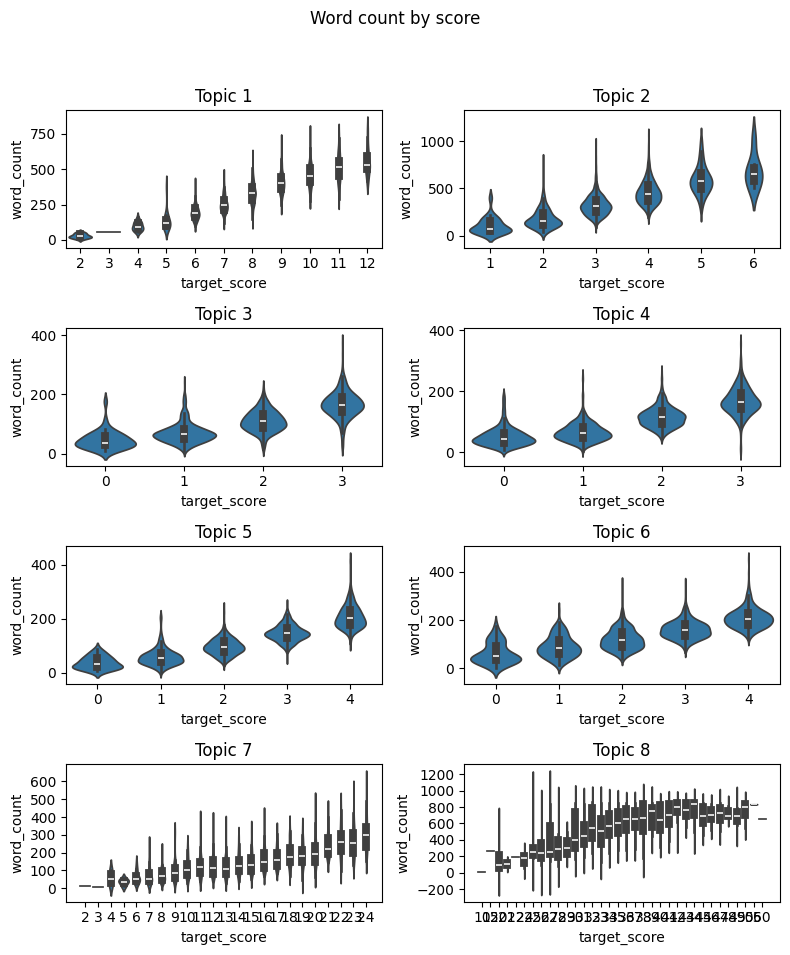

In [5]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
from datetime import datetime
import language_tool_python
from tqdm.auto import tqdm

# Enable tqdm for pandas
tqdm.pandas()

tool = language_tool_python.LanguageTool('en-US')
print("LanguageTool server started")

t0 = datetime.now()

training_set['matches'] = training_set['essay'].progress_apply(
    lambda txt: tool.check(txt)
)

training_set['corrections'] = training_set['matches'].apply(len)

training_set['corrected'] = training_set['essay'].progress_apply(
    lambda txt: tool.correct(txt)
)

t1 = datetime.now()

training_set.to_pickle('training_corr.pkl')

tool.close()


In [12]:
training_set = pd.read_pickle('training_corr.pkl')

In [13]:
from tqdm import tqdm
import spacy
import numpy as np
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from datetime import datetime

# Define stop words
stop_words = set(STOP_WORDS)
stop_words.update(punctuation)

nlp = spacy.load('en_core_web_sm')

# Initialize lists
sents = []
tokens = []
lemma = []
pos = []
ner = []

t0 = datetime.now()

# Use tqdm with nlp.pipe
for essay in tqdm(nlp.pipe(training_set['corrected'], batch_size=100, n_process=3), 
                  total=len(training_set), desc="Processing essays"):
    if essay.is_parsed:
        tokens.append([e.text for e in essay if e.text.lower() not in stop_words])
        sents.append([sent.text.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # Keep alignment with dataframe
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

# Add to DataFrame
training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))


Processing essays:   0%|                                                                     | 0/12976 [00:00<?, ?it/s]C:\Users\Dell\AppData\Local\Temp\ipykernel_2796\248792127.py:26: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if essay.is_parsed:
Processing essays: 100%|█████████████████████████████████████████████████████████| 12976/12976 [10:32<00:00, 20.51it/s]

Processing time: 0:10:32.797556


In [14]:
training_set.to_pickle('training_spacy.pkl')

In [4]:
training_set = pd.read_pickle('training_spacy.pkl')

In [8]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, think, effects, compu...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN...","[Dear local newspaper, I think effects compute...",[all day]
1,"[Dear, @CAPS1, @CAPS2, believe, computers, ben...","[PROPN, PROPN, PROPN, PUNCT, PRON, VERB, SCONJ...","[Dear @CAPS1 @CAPS2, I believe that using comp...","[Facebook and MySpace, millions, one, MySpace,..."
2,"[Dear, @CAPS1, @CAPS2, @CAPS3, people, use, co...","[ADJ, PUNCT, PROPN, PROPN, PROPN, ADJ, CCONJ, ...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more peop...","[today, one, @CAPS4, one, a thousand]"
3,"[Dear, Local, Newspaper, @CAPS1, found, expert...","[PROPN, PROPN, PROPN, PUNCT, PROPN, PRON, AUX,...","[Dear Local Newspaper, @CAPS1 I have found tha...","[Dear Local Newspaper, @PERSON1, @PERCENT2, Ne..."
4,"[Dear, @LOCATION1, know, having, computers, po...","[ADJ, PROPN, PUNCT, PRON, VERB, VERB, NOUN, VE...","[Dear @LOCATION1, I know having computers has ...","[First, hours, one, Secondly, one, only one]"


In [5]:
# Replace topic numbers with meaningful one-word summary:
topic_dict = {'topic':{1: 'computer', 
                       2: 'censorship', 
                       3: 'cyclist', 
                       4: 'hibiscus', 
                       5: 'mood', 
                       6: 'dirigibles', 
                       7: 'patience', 
                       8: 'laughter'}}

training_set.replace(topic_dict, inplace=True)

# Lemmatized essays re-joined (list to essay)
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_df=0.2,
    min_df=3,
    stop_words=list(STOP_WORDS),
    max_features=2000
)

doc_term_matrix = vectorizer.fit_transform(training_set.l_essay)

# Updated sklearn API
words = vectorizer.get_feature_names_out()

# Updated pandas API
doc_term_matrix_df = pd.DataFrame.sparse.from_spmatrix(
    doc_term_matrix,
    columns=words
)

word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head(10)


C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


computer     20383
book         13982
building      7815
library       7610
dirigible     6239
read          6123
child         5775
help          5191
offensive     5117
talk          4979
dtype: int64

In [7]:
lda_base = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=40,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda_base.fit(doc_term_matrix)

# save base model
import joblib
joblib.dump(lda_base, 'lda_baseline.pkl')

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40, perplexity: 368.7689
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40, perplexity: 367.9739
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40, perplexity: 366.9914
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40, perplexity: 365.7745
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40, perplexity: 365.4153
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40

['lda_baseline.pkl']

In [8]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 9)]
topics_count = lda_base.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
response,0.000003,1.788320e-04,0.000110,1.051908e-04,0.000002,0.000197,0.000001,2.745402e-05
alike,0.000003,1.274251e-04,0.000044,2.789596e-05,0.000019,0.000041,0.000001,1.163898e-04
relative,0.000217,7.251470e-07,0.000002,8.420064e-04,0.004363,0.000003,0.000001,6.698967e-07
bet,0.000003,1.210211e-04,0.000096,1.537086e-04,0.000002,0.000003,0.000001,1.334458e-04
narrator,0.000003,7.247781e-07,0.000824,6.745441e-07,0.000550,0.001204,0.000001,6.689522e-07
thinking,0.000503,5.151931e-05,0.000033,7.415257e-05,0.000020,0.000131,0.000017,1.107772e-04
happy,0.015858,2.206965e-03,0.000002,3.188512e-04,0.022681,0.001526,0.000001,5.699783e-04
unsafe,0.000003,7.242797e-07,0.000041,5.382398e-05,0.000002,0.000003,0.001658,7.257321e-06
glance,0.000003,2.616364e-04,0.000002,6.748487e-07,0.000002,0.000003,0.000001,3.792728e-05
safety,0.000003,4.520150e-05,0.000002,2.319085e-04,0.000002,0.000003,0.007672,1.178961e-04


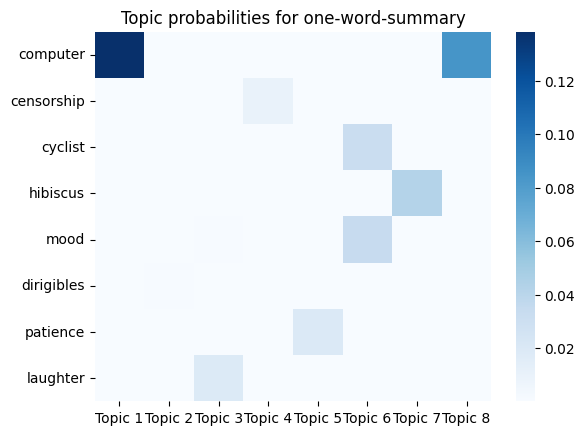

In [24]:
one_word = list(topic_dict['topic'].values())
sns.heatmap(topics.reindex(one_word), cmap='Blues')
plt.title('Topic probabilities for one-word-summary')
plt.show()

In [9]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,laughter,laugh,cyclist,computer,mood,test,building,book
1,feel,patient,water,help,memoir,sang,dirigible,library
2,relationship,wait,setting,talk,love,hibiscus,obstacle,read
3,person,person1,affect,learn,narcissa,paragraph,empire,offensive
4,talk,caps3,feature,spend,create,conclude,mast,child
5,happy,caps4,road,reason,grateful,plant,builder,movie
6,bring,tell,desert,online,happy,spring,dock,shelf
7,smile,start,hill,effect,rodriguez,end,face,music
8,important,mom,hot,exercise,house,winter,mooring,material
9,help,caps5,town,internet,paragraph,flower,wind,magazine


In [10]:
train_preds = lda_base.transform(doc_term_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=training_set.topic)
train_eval.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
topic,,,,,,,,
dirigibles,0.051459,0.002237,0.002233,0.059469,0.002235,0.002234,0.877896,0.002238
censorship,0.001129,0.001128,0.001127,0.001127,0.001127,0.001127,0.001127,0.992108
hibiscus,0.004478,0.004472,0.004466,0.004469,0.004467,0.968714,0.004465,0.004470
dirigibles,0.011950,0.001070,0.001069,0.001070,0.001070,0.001069,0.981633,0.001069
computer,0.002162,0.082654,0.002157,0.904394,0.002160,0.002159,0.002157,0.002156
cyclist,0.002843,0.002844,0.930084,0.002845,0.002842,0.052851,0.002847,0.002844
censorship,0.048087,0.000977,0.000977,0.000979,0.000978,0.000978,0.000977,0.946047
cyclist,0.002719,0.002720,0.980966,0.002718,0.002719,0.002721,0.002718,0.002719
cyclist,0.001840,0.001839,0.987124,0.001839,0.001839,0.001839,0.001840,0.001839


,topic,assignment
0,censorship,Topic 4
1,computer,Topic 8
2,cyclist,Topic 6
3,dirigibles,Topic 2
4,hibiscus,Topic 7
5,laughter,Topic 3
6,mood,Topic 6
7,patience,Topic 5


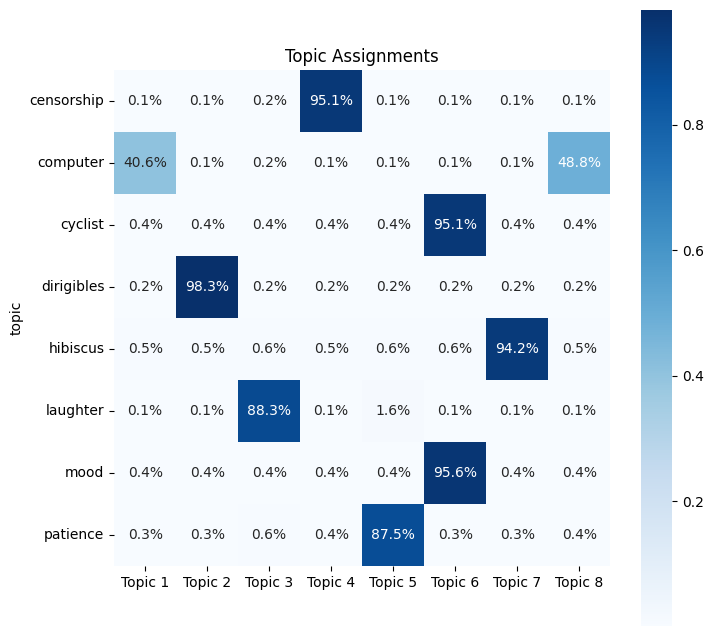

In [28]:
df = train_eval.groupby(level='topic').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Blues', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Topic Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('topic', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

In [11]:
def show_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx}:")
        print(" ".join(words[i] for i in topic.argsort()[-top_n:]))

show_topics(lda_base, vectorizer)



Topic 0:
help important smile bring happy talk person relationship feel laughter

Topic 1:
caps5 mom start tell caps4 caps3 person1 wait patient laugh

Topic 2:
town hot hill desert road feature affect setting water cyclist

Topic 3:
internet exercise effect online reason spend learn talk help computer

Topic 4:
paragraph house rodriguez happy grateful create narcissa love memoir mood

Topic 5:
flower winter end spring plant conclude paragraph hibiscus sang test

Topic 6:
wind mooring face dock builder mast empire obstacle dirigible building

Topic 7:
magazine material music shelf movie child offensive read library book


In [12]:
from sklearn.model_selection import train_test_split

hibiscus = training_set[training_set.topic == 'hibiscus']

# Split essays into training and test sets
train_essays, test_essays = train_test_split(hibiscus, 
                                         stratify=hibiscus.target_score, 
                                         test_size=0.2, 
                                         random_state=42)

In [13]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=list(STOP_WORDS), 
                             max_features=2000) # limit to account for smaller set of essays

# Train and test doc-term matrices
train_dtm = vectorizer.fit_transform(train_essays.l_essay)
test_dtm = vectorizer.transform(test_essays.l_essay)

C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [14]:
lda_score = LatentDirichletAllocation(n_components=4,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     evaluate_every=5,
                                     verbose=1, 
                                     max_iter=500)
lda_score.fit(train_dtm)

# save training model
joblib.dump(lda_score, 'lda_score.pkl')

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 480.1057
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 463.1275
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 458.7467
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 456.3690
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 454.7879
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500


['lda_score.pkl']

In [19]:
# First, let's check what columns your DataFrame actually has
print("Available columns in your DataFrame:\n")
print(train_essays.columns.tolist())

# Option 1: Use your existing 4-topic LDA
topic_labels = ['Analytical_Writing', 'Vague_Language', 'Structured_Argument', 'Topic_Vocabulary']

train_preds = lda_score.transform(train_dtm)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_essays.target_score)

print("\n\n4-Topic Distribution Sample:")
print(train_eval.sample(5))

Available columns in your DataFrame:

['essay_id', 'topic', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2', 'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'matches', 'corrections', 'corrected', 'tokens', 'lemma', 'pos', 'sents', 'ner', 'l_essay']


4-Topic Distribution Sample:
              Analytical_Writing  Vague_Language  Structured_Argument  \
target_score                                                            
2                       0.044557        0.042541             0.870017   
1                       0.128689        0.125018             0.128743   
2                       0.011434        0.011716             0.429549   
0             

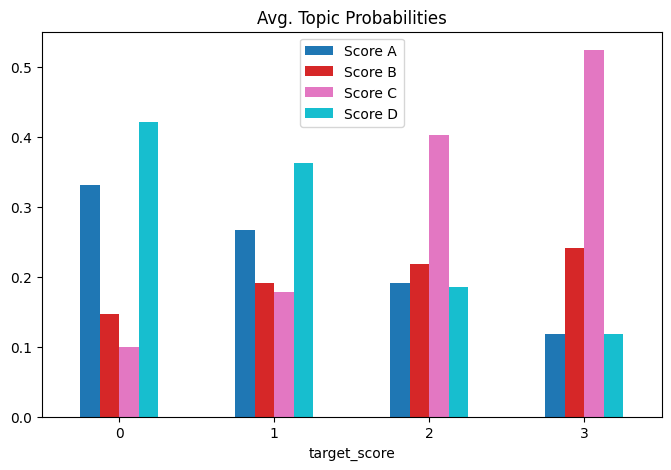

In [26]:
train_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(8,5));

,target_score,assignment
0,0,Score D
1,1,Score D
2,2,Score C
3,3,Score C


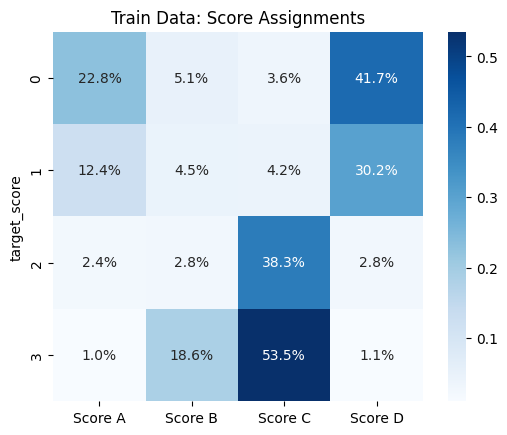

In [27]:
df = train_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Score Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('target_score', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

In [30]:
test_preds = lda_score.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_essays.target_score)
test_eval.head()

,Score A,Score B,Score C,Score D
target_score,,,,
2,0.126840,0.290107,0.572044,0.011008
3,0.006828,0.179214,0.806741,0.007218
0,0.291257,0.499451,0.024176,0.185116
1,0.006422,0.286758,0.190214,0.516607
1,0.543136,0.396625,0.029031,0.031207


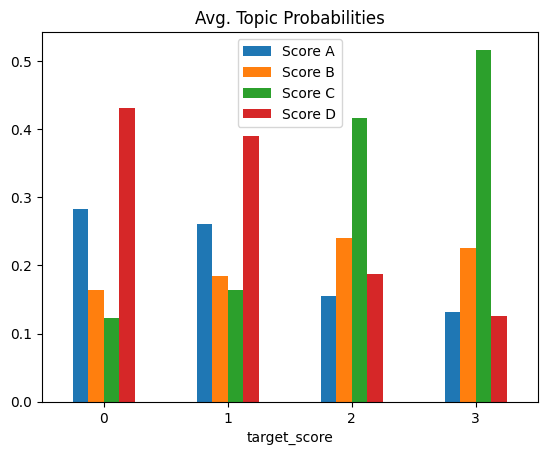

In [31]:
test_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0);

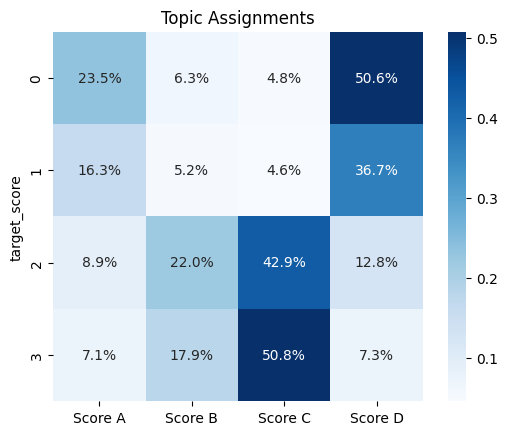

In [32]:
df = test_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments')
plt.show()

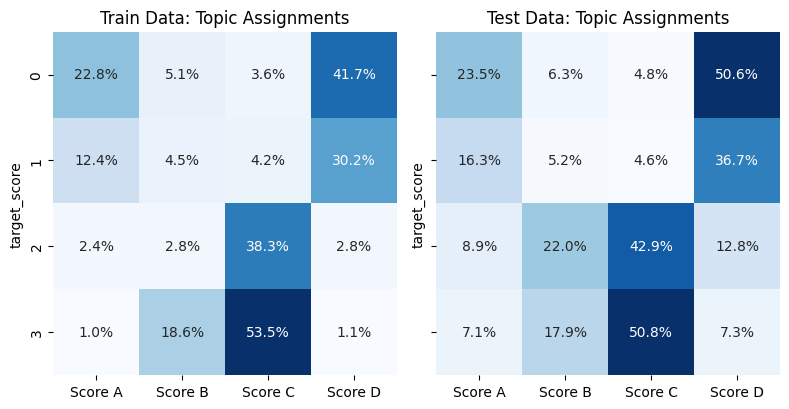

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), sharey=True)
source = ['Train', 'Test']
for i, df in enumerate([train_eval, test_eval]):
    df = df.groupby(level='target_score').agg('median')
    sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i], cbar=False)
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))
plt.tight_layout()
plt.show()

In [43]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import requests

def grammar_check_remote(text):
    """Check grammar using LanguageTool public API"""
    try:
        response = requests.post(
            'https://api.languagetool.org/v2/check',
            data={
                'text': text,
                'language': 'en-US'
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            return len(result['matches'])
        else:
            return 0
    except:
        return 0

def correct_text_remote(text):
    """Correct text using LanguageTool public API"""
    try:
        response = requests.post(
            'https://api.languagetool.org/v2/check',
            data={
                'text': text,
                'language': 'en-US'
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            corrected = text
            # Apply corrections (simplified)
            for match in reversed(result['matches']):
                if match['replacements']:
                    start = match['offset']
                    end = start + match['length']
                    corrected = corrected[:start] + match['replacements'][0]['value'] + corrected[end:]
            return corrected
        else:
            return text
    except:
        return text

# 1. Prepare features for scoring - FIXED VERSION
def prepare_scoring_features(essays_df, lda_model, vectorizer):
    """Create features for scoring model - handles missing columns"""
    
    # Get topic probabilities from LDA model
    essay_vectors = vectorizer.transform(essays_df['l_essay'])
    topic_probs = lda_model.transform(essay_vectors)
    
    # Create features DataFrame
    features_df = pd.DataFrame(topic_probs, columns=topic_labels)
    
    # Add basic features - with error handling
    try:
        features_df['word_count'] = essays_df['word_count'].values
    except KeyError:
        # Calculate word count if column doesn't exist
        features_df['word_count'] = essays_df['l_essay'].apply(lambda x: len(x.split()))
        print("✓ Calculated word_count from l_essay")
    
    try:
        features_df['grammar_errors'] = essays_df['corrections'].values
    except KeyError:
        # Set to 0 if corrections column doesn't exist
        features_df['grammar_errors'] = 0
        print("✓ Set grammar_errors to 0 (column not found)")
    
    try:
        features_df['avg_sentence_length'] = essays_df['sents'].apply(
            lambda x: np.mean([len(sent.split()) for sent in x]) if x else 0
        )
    except KeyError:
        # Calculate from raw text if sents column doesn't exist
        features_df['avg_sentence_length'] = essays_df['l_essay'].apply(
            lambda x: np.mean([len(sent.split()) for sent in x.split('.') if sent.strip()]) if x else 0
        )
        print("✓ Calculated avg_sentence_length from l_essay")
    
    print(f"Created features with shape: {features_df.shape}")
    return features_df

# Create features
print("Creating features...")
X_train = prepare_scoring_features(train_essays, lda_score, vectorizer)
X_test = prepare_scoring_features(test_essays, lda_score, vectorizer)

# Replace infinity with NaN then fill
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Handle NaN values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

y_train = train_essays['target_score']
y_test = test_essays['target_score']

y_train = (y_train / 3 * 9) + 1  # Maps 0→1, 3→10
y_test = (y_test / 3 * 9) + 1    # Maps 0→1, 3→10

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# 2. Train scoring models
print("Training scoring models...")

# Model 1: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Model 2: Gradient Boosting  
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

def predict_essay_score_with_feedback(essay_text, model=rf_model):
    """Predict score with detailed feedback"""
    nlp = spacy.load('en_core_web_sm')
    
    try:
        # Grammar and spelling analysis
        try:
            response = requests.post(
                'https://api.languagetool.org/v2/check',
                data={'text': essay_text, 'language': 'en-US'},
                timeout=10
            )
            if response.status_code == 200:
                result = response.json()
                grammar_errors = len([m for m in result['matches'] if m['rule']['category']['id'] == 'GRAMMAR'])
                spelling_errors = len([m for m in result['matches'] if m['rule']['category']['id'] == 'TYPOS'])
                total_errors = len(result['matches'])
                
                # Get specific error examples
                error_examples = []
                for match in result['matches'][:3]:  # Show first 3 errors
                    error_examples.append(f"- {match['message']} ('{match['context']['text']}')")
            else:
                grammar_errors = spelling_errors = total_errors = 0
                error_examples = ["Could not analyze grammar"]
        except:
            grammar_errors = spelling_errors = total_errors = 0
            error_examples = ["Grammar check unavailable"]
        
        # SpaCy processing for other features
        doc = nlp(essay_text)
        lemmatized = ' '.join([token.lemma_ for token in doc])
        
        # Create features and predict
        essay_vector = vectorizer.transform([lemmatized])
        topic_probs = lda_score.transform(essay_vector)
        
        features = pd.DataFrame(topic_probs, columns=topic_labels)
        features['word_count'] = len(essay_text.split())
        features['grammar_errors'] = total_errors
        features['avg_sentence_length'] = np.mean([len(sent.text.split()) for sent in doc.sents])
        
        predicted_score = model.predict(features)[0]
        final_score = max(1, min(10, round(predicted_score, 1)))
        
        # Generate feedback
        feedback = generate_feedback(final_score, grammar_errors, spelling_errors, 
                                   features.iloc[0], error_examples, len(essay_text.split()))
        
        return final_score, feedback
        
    except Exception as e:
        return 5.0, f"Error: {e}"
def generate_feedback(score, grammar_errors, spelling_errors, features, error_examples, word_count):
    """Generate personalized feedback with exact issues"""
    feedback = []
    
    # Score feedback
    if score >= 8:
        feedback.append("🎉 Excellent essay! Strong content and structure.")
    elif score >= 6:
        feedback.append("👍 Good essay with solid organization.")
    elif score >= 4:
        feedback.append("📝 Average essay - room for improvement.")
    else:
        feedback.append("📚 Needs significant improvement in content and structure.")
    
    # Grammar and spelling feedback with EXACT issues
    if error_examples and not "Could not analyze" in error_examples[0]:
        feedback.append(f"\n🔧 GRAMMAR & SPELLING ISSUES ({grammar_errors + spelling_errors} total):")
        for i, example in enumerate(error_examples[:5], 1):  # Show first 5 exact issues
            feedback.append(f"   {i}. {example}")
    else:
        if grammar_errors > 0 or spelling_errors > 0:
            feedback.append(f"⚠️  {grammar_errors} grammar errors, {spelling_errors} spelling errors")
        else:
            feedback.append("✅ Excellent grammar and spelling")
    
    # Topic analysis feedback
    dominant_topic = features[topic_labels].idxmax()
    topic_strength = features[dominant_topic]
    
    if topic_strength > 0.6:
        feedback.append(f"\n📊 WRITING STYLE: Strong focus on {dominant_topic.replace('_', ' ').lower()}")
    else:
        feedback.append("\n📊 WRITING STYLE: Balanced use of different writing styles")
    
    # Word count feedback
    if word_count < 100:
        feedback.append("📏 LENGTH: Essay is too short - develop ideas more")
    elif word_count > 500:
        feedback.append("📏 LENGTH: Good length - comprehensive coverage")
    else:
        feedback.append("📏 LENGTH: Appropriate for the topic")
    
    return "\n".join(feedback)

# Usage:
score, feedback = predict_essay_score_with_feedback("Your essay text")
print(f"Score: {score}/10")
print(f"Feedback:\n{feedback}")

# 3. Evaluate models
print("\n📊 MODEL PERFORMANCE:")

def evaluate_predictions(true_scores, pred_scores, model_name):
    mae = mean_absolute_error(true_scores, pred_scores)
    r2 = r2_score(true_scores, pred_scores)
    within_1 = np.mean(np.abs(true_scores - pred_scores) <= 1)
    
    print(f"\n{model_name}:")
    print(f"  MAE: {mae:.3f}")
    print(f"  R²: {r2:.3f}") 
    print(f"  Within 1 point: {within_1:.1%}")
    
    return mae, r2

# Test predictions
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

evaluate_predictions(y_test, rf_pred, "Random Forest")
evaluate_predictions(y_test, gb_pred, "Gradient Boosting")

# DEBUG: Check what scores your training data actually has
print("Training score distribution:")
print(y_train.value_counts().sort_index())

# DEBUG: Check feature ranges
print("\nFeature ranges in training data:")
print(X_train.describe())

# DEBUG: Test prediction on training data itself
sample_train_pred = rf_model.predict(X_train.iloc[:2])
print(f"\nPrediction on training samples: {sample_train_pred}")

# 4. PREDICTION FUNCTION - FIXED VERSION
def predict_essay_score(essay_text, model=rf_model):
    """Predict score for a new essay - robust version"""
    nlp = spacy.load('en_core_web_sm')
    try:
        corrected = correct_text_remote(essay_text)
        # Grammar correction
        # try:
        #     corrected = tool.correct(essay_text)
        # except:
        #     corrected = essay_text
        #     print("⚠️  LanguageTool not available, using original text")
    
        # SpaCy processing
        doc = nlp(corrected)
        lemmatized = ' '.join([token.lemma_ for token in doc])
        
        # Create features
        essay_vector = vectorizer.transform([lemmatized])
        topic_probs = lda_score.transform(essay_vector)
        
        features = pd.DataFrame(topic_probs, columns=topic_labels)
        features['word_count'] = len(essay_text.split())
        
        # Try to get grammar errors, but don't fail if tool isn't available
        try:
            features['grammar_errors'] = len(grammar_errors = grammar_check_remote(essay_text))
        except:
            features['grammar_errors'] = 0
            
        features['avg_sentence_length'] = np.mean([len(sent.text.split()) for sent in doc.sents])
        
        # Predict score
        predicted_score = model.predict(features)[0]
        final_score = max(1, min(10, round(predicted_score, 1)))
        
        return final_score
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        # Return a default score or handle error as needed
        return 5.0  # Middle score as fallback
# REPLACE your current testing section with this:

# 5. TEST PREDICTIONS WITH FEEDBACK
print("\n🎯 TESTING PREDICTIONS WITH FEEDBACK:")
print("=" * 50)

sample_essays = [
    {
        'text': """ï¿½Winter Hibiscus ï¿½is about a girl saeng, who moved from Vietnam to the @ORGANIZATION1. After she fails her driverï¿½s test. She walks home and finds a hibiscus. ï¿½She closed her eyes and breathed in, deeply. The familiar fragrance filled her lungs, and saeng could almost feel the light strands of her grandmotherï¿½s long gray hairï¿½ï¿½ She goes to a flower shop to see if it can be purchased. She pays a lot of money for the plant because it is rare and valuable. It is special to her because she used to have hibiscus plants in Vietnam. She brings the plant home & tells her mom that it reminds her of Vietnam. The mom says that it reminds her of Vietnam too. The mom is not happy with how much saeng paid for it. She plants it in her garden.ï¿½ When the hibiscus was lowered in the ground, a flock of geese flew by.ï¿½When the hibiscus returns in the spring,  saeng will take her driverï¿½s test again. In the spring, all the flowers start to bud and bloom. Everything is new again. saeng will have a new chance to pass her test.""",
        'description': 'Good quality essay'
    },
    {
        'text': """Hibiscus flower pretty. It red. Grow warm. Make tea.""", 
        'description': 'Poor quality essay'
    }
]

for i, essay in enumerate(sample_essays, 1):
    try:
        print(f"\n📝 Essay {i} ({essay['description']}):")
        print("-" * 40)
        
        # Get score and feedback
        rf_score, rf_feedback = predict_essay_score_with_feedback(essay['text'], rf_model)
        gb_score, gb_feedback = predict_essay_score_with_feedback(essay['text'], gb_model)
        
        print(f"🤖 Random Forest: {rf_score}/10")
        print(f"📊 Gradient Boost: {gb_score}/10")
        print(f"📈 Average Score: {(rf_score + gb_score)/2:.1f}/10")
        
        print(f"\n💡 FEEDBACK (Random Forest):")
        print(rf_feedback)
        
    except Exception as e:
        print(f"❌ Failed to score essay {i}: {e}")

# 6. Save models
print("\n💾 SAVING MODELS...")
joblib.dump(rf_model, 'essay_scorer_rf.pkl')
joblib.dump(gb_model, 'essay_scorer_gb.pkl') 
joblib.dump(vectorizer, 'essay_vectorizer.pkl')
joblib.dump(lda_score, 'essay_lda_model.pkl')

print("✅ Models saved: essay_scorer_rf.pkl, essay_scorer_gb.pkl")

Creating features...
✓ Calculated word_count from l_essay
Created features with shape: (1416, 7)
✓ Calculated word_count from l_essay
Created features with shape: (354, 7)
Training features shape: (1416, 7)
Test features shape: (354, 7)
Training scoring models...
Score: 3.4/10
Feedback:
📚 Needs significant improvement in content and structure.
✅ Excellent grammar and spelling

📊 WRITING STYLE: Balanced use of different writing styles
📏 LENGTH: Essay is too short - develop ideas more

📊 MODEL PERFORMANCE:

Random Forest:
  MAE: 1.458
  R²: 0.554
  Within 1 point: 41.5%

Gradient Boosting:
  MAE: 1.499
  R²: 0.545
  Within 1 point: 41.0%
Training score distribution:
target_score
1.0     249
4.0     509
7.0     456
10.0    202
Name: count, dtype: int64

Feature ranges in training data:
       Analytical_Writing  Vague_Language  Structured_Argument  \
count         1416.000000     1416.000000          1416.000000   
mean             0.281892        0.244193             0.233662   
std     

In [28]:
pip install language-tool-python

Note: you may need to restart the kernel to use updated packages.
